In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from fastseg import MobileV3Small
from fastseg.image.colorize import colorize, blend
from dataloader import UROBDataset
import torchvision.transforms as transforms
import torchvision
import cv2
from PIL import Image
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda:0'
if not torch.cuda.is_available():
    device = 'cpu'

print(device)

cuda:0


In [3]:

# construct the dataset
target_shape = [512, 1024]
train_dataset = UROBDataset(filenames_file='./filenames.pkl', target_img_shape=target_shape)
batch_size = 1

# construct the dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomAffine(20),
     transforms.RandomAutocontrast()
])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)


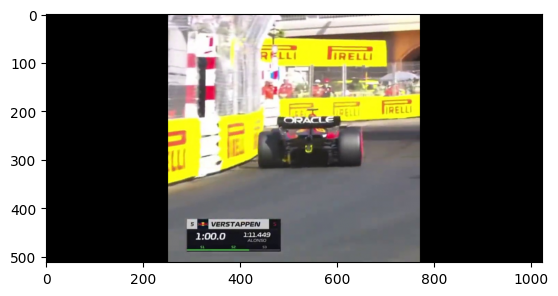

In [4]:
def imshow(img):
    img = (img + 1) / 2  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
for i in range(images.shape[0]):
    imshow(images[i, :, :, :])


In [5]:

# define model and optimizer

learning_rate = 1e-3
weight_decay = learning_rate * 1e-2
num_epoch = 20

model = MobileV3Small(num_classes=19)
model = model.to(device=device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.9)
criterion = torch.nn.CrossEntropyLoss(reduction="none", weight=None) # TODO() add ignore label


In [6]:

best_val_loss = np.infty

def validate(val_dataloader, model):

    print(' ------- VALIDATING ------- ')
    pbar = tqdm(total=len(val_dataloader))
    model.eval()

    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for val_iter, val_data in enumerate(val_dataloader):

            X_val, y_val = val_data
            X_val = X_val.float().to(device=device)
            y_val = y_val.long().to(device=device)      
            
            output = model(X_val)
            predict_labels = torch.argmax(output, dim=1)

            # TODO() compute more metrics
            acc = torch.sum(predict_labels == y_val) / y_val.numel()


    model.train()

for epoch in range(num_epoch):

    pbar = tqdm(total=len(trainloader))

    for iter, data in enumerate(trainloader):
        X_trn, y_trn = data
        # TODO() augmentation to the dataloader
        # run through model
        X_trn = X_trn.float().to(device=device)
        y_trn = y_trn.long().to(device=device)
        output = model(X_trn)

        # compute loss
        loss = criterion(output, y_trn)
        loss = loss.mean()
        pbar.set_description(f'epoch: {epoch} | loss: {loss.item():.3}')

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.update(batch_size)
    pbar.close()
    lr_scheduler.step()

loss: 0.11:  88%|████████▊ | 895/1012 [02:25<00:17,  6.57it/s]   

KeyboardInterrupt: 